# 7. BIST50 Transformer Modelleri - Tek Hisse (DÜZELTİLMİŞ)

**Modeller:** Informer, Autoformer, TimesNet, DeepAR, TFT, TSMixer (NeuralForecast)

**Veri:** Tek hisse × 250 gün (Az Veri)

**Düzeltme:** Her periyot için AYRI model eğitiliyor (1, 10, 21 gün)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Gerekli kütüphaneleri kur
!pip install -q neuralforecast pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.2/263.2 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.4/72.4 MB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 67.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 9.6 MB/s eta 0:00:00


In [3]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from math import sqrt
import torch
import os

# NeuralForecast
from neuralforecast import NeuralForecast
from neuralforecast.models import Informer, Autoformer, TimesNet, DeepAR, TFT, TSMixer

plt.style.use('fivethirtyeight')

# GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

# Parametreler
TEST_SIZE = 21
INPUT_SIZE = 30

# Tahmin periyotları - HER BİRİ İÇİN AYRI MODEL EĞİTİLECEK
TAHMIN_PERIYOTLARI = {
    '1_gun': 1,
    '10_gun': 10,
    '21_gun': 21
}

# Yollar
DATA_FILE = "/content/drive/MyDrive/Colab Notebooks/tez/Data/BIST_50_2018_Data.csv"
RESULTS_DIR = '/content/drive/MyDrive/Colab Notebooks/Sonuclar/7_Transformers'
os.makedirs(RESULTS_DIR, exist_ok=True)

NOTEBOOK_ADI = "7_Transformers"
VERI_TIPI = "az_veri"
KATEGORI = "Transformer"

print(f"Veri: {DATA_FILE}")
print(f"Sonuç Dizini: {RESULTS_DIR}")

Device: cuda
Veri: /content/drive/MyDrive/Colab Notebooks/tez/Data/BIST_50_2018_Data.csv
Sonuç Dizini: /content/drive/MyDrive/Colab Notebooks/Sonuclar/7_Transformers


In [4]:
# Güvenli metrik hesaplama
def calculate_metrics_safe(y_true, y_pred, model_name):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    nan_count = np.isnan(y_pred).sum()
    if nan_count > 0:
        print(f"  {nan_count} NaN, interpolasyon...")
    y_pred = pd.Series(y_pred).interpolate().bfill().ffill().values

    valid = ~np.isnan(y_pred) & ~np.isnan(y_true)
    if valid.sum() == 0:
        return np.nan, np.nan, np.nan, np.nan, y_pred

    rmse = sqrt(mean_squared_error(y_true[valid], y_pred[valid]))
    mae = mean_absolute_error(y_true[valid], y_pred[valid])
    r2 = r2_score(y_true[valid], y_pred[valid])
    mape = mean_absolute_percentage_error(y_true[valid], y_pred[valid]) * 100
    return rmse, mae, r2, mape, y_pred

In [5]:
# Veri yükle
print("Veri yükleniyor...")
df_raw = pd.read_csv(DATA_FILE)

if 'Now' in df_raw.columns:
    df_raw = df_raw.rename(columns={'Now': 'Close'})

df_raw['Date'] = pd.to_datetime(df_raw['Date'], format='%d.%m.%Y')

if df_raw['Close'].dtype == 'object':
    df_raw['Close'] = df_raw['Close'].str.replace('.', '', regex=False).str.replace(',', '.', regex=False).astype(float)

df = df_raw[['Date', 'Close']].dropna().sort_values('Date').reset_index(drop=True)

print(f"Toplam: {len(df)} gün")
print(f"Tarih: {df['Date'].min()} - {df['Date'].max()}")

# Train/Test
train_df = df.iloc[:-TEST_SIZE].copy()
test_df = df.iloc[-TEST_SIZE:].copy()

print(f"Train: {len(train_df)}, Test: {len(test_df)}")

# NeuralForecast formatı
train_nf = train_df.rename(columns={'Date': 'ds', 'Close': 'y'})
train_nf['unique_id'] = 'BIST50'
train_nf = train_nf[['unique_id', 'ds', 'y']]

print(f"NeuralForecast format hazır: {train_nf.shape}")

Veri yükleniyor...
Toplam: 250 gün
Tarih: 2018-01-02 00:00:00 - 2018-12-31 00:00:00
Train: 229, Test: 21
NeuralForecast format hazır: (229, 3)


In [6]:
# =============================================================================
# HER PERİYOT İÇİN AYRI MODEL EĞİTİMİ
# =============================================================================
print("=" * 80)
print(" HER PERİYOT İÇİN AYRI MODEL EĞİTİMİ")
print("=" * 80)

tum_sonuclar = []

for periyot_adi, horizon in TAHMIN_PERIYOTLARI.items():
    print(f"\n{'='*70}")
    print(f" {periyot_adi.upper()} ({horizon} gün) için model eğitimi başlıyor...")
    print('='*70)

    # Bu periyot için gerçek değerler
    y_true = test_df['Close'].values[:horizon]

    # Model listesi - her periyot için yeniden oluştur
    model_configs = {
        'Informer': lambda h: Informer(h=h, input_size=INPUT_SIZE, hidden_size=64, n_head=8,
                                        learning_rate=1e-3, max_steps=500, batch_size=32,
                                        random_seed=42, scaler_type='standard'),
        'Autoformer': lambda h: Autoformer(h=h, input_size=INPUT_SIZE, hidden_size=64, n_head=8,
                                           learning_rate=1e-3, max_steps=500, batch_size=32,
                                           random_seed=42, scaler_type='standard'),
        'TimesNet': lambda h: TimesNet(h=h, input_size=INPUT_SIZE, hidden_size=64,
                                        learning_rate=1e-3, max_steps=500, batch_size=32,
                                        random_seed=42, scaler_type='standard'),
        'DeepAR': lambda h: DeepAR(h=h, input_size=INPUT_SIZE, lstm_n_layers=2, lstm_hidden_size=64,
                                    learning_rate=1e-3, max_steps=500, batch_size=32,
                                    random_seed=42, scaler_type='standard'),
        'TFT': lambda h: TFT(h=h, input_size=INPUT_SIZE, hidden_size=64, n_head=8,
                             learning_rate=1e-3, max_steps=500, batch_size=32,
                             random_seed=42, scaler_type='standard'),
        'TSMixer': lambda h: TSMixer(h=h, input_size=INPUT_SIZE, n_series=1, n_block=2, ff_dim=64,
                                      learning_rate=1e-3, max_steps=500, batch_size=32,
                                      random_seed=42, scaler_type='standard')
    }

    for model_name, model_fn in model_configs.items():
        print(f"\n  🔄 {model_name} eğitiliyor ({periyot_adi}, horizon={horizon})...")

        try:
            # Model oluştur (bu periyot için)
            model = model_fn(horizon)

            # Eğit
            nf = NeuralForecast(models=[model], freq='D')
            nf.fit(df=train_nf)

            # Tahmin
            pred = nf.predict().reset_index()
            y_pred = pred[model_name].values[:len(y_true)]

            # Metrikler
            rmse, mae, r2, mape, y_pred = calculate_metrics_safe(y_true, y_pred, model_name)

            print(f"     ✓ {model_name} ({periyot_adi}): RMSE={rmse:.4f}, MAE={mae:.4f}, R²={r2:.4f}")

            tum_sonuclar.append({
                'Notebook': NOTEBOOK_ADI,
                'Model': model_name,
                'Kategori': KATEGORI,
                'Veri_Tipi': VERI_TIPI,
                'Periyot': periyot_adi,
                'Periyot_Gun': horizon,
                'RMSE': round(rmse, 4) if not np.isnan(rmse) else np.nan,
                'MAE': round(mae, 4) if not np.isnan(mae) else np.nan,
                'R2': round(r2, 4) if not np.isnan(r2) else np.nan,
                'MAPE': round(mape, 4) if not np.isnan(mape) else np.nan
            })

        except Exception as e:
            print(f"     ❌ {model_name} ({periyot_adi}): HATA - {str(e)[:100]}")
            tum_sonuclar.append({
                'Notebook': NOTEBOOK_ADI,
                'Model': model_name,
                'Kategori': KATEGORI,
                'Veri_Tipi': VERI_TIPI,
                'Periyot': periyot_adi,
                'Periyot_Gun': horizon,
                'RMSE': np.nan,
                'MAE': np.nan,
                'R2': np.nan,
                'MAPE': np.nan
            })

sonuc_df = pd.DataFrame(tum_sonuclar)
print(f"\n✅ Toplam {len(sonuc_df)} test tamamlandı!")

INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


 HER PERİYOT İÇİN AYRI MODEL EĞİTİMİ

 1_GUN (1 gün) için model eğitimi başlıyor...

  🔄 Informer eğitiliyor (1_gun, horizon=1)...


INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss          │ MAE           │      0 │ train │     0 │
│ 1 │ padder_train  │ ConstantPad1d │      0 │ train │     0 │
│ 2 │ scaler        │ TemporalNorm  │      0 │ train │     0 │
│ 3 │ enc_embedding │ DataEmbedding │    192 │ train │     0 │
│ 4 │ dec_embedding │ DataEmbedding │    192 │ train │     0 │
│ 5 │ encoder       │ TransEncoder  │ 54.8 K │ train │     0 │
│ 6 │ decoder       │ TransDecoder  │ 38.0 K │ train │     0 │
└───┴───────────────┴───────────────┴────────┴───────┴───────┘

Trainable params: 93.2 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 93.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 73                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


     ✓ Informer (1_gun): RMSE=4.3543, MAE=4.3543, R²=nan

  🔄 Autoformer eğitiliyor (1_gun, horizon=1)...


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss          │ MAE           │      0 │ train │     0 │
│ 1 │ padder_train  │ ConstantPad1d │      0 │ train │     0 │
│ 2 │ scaler        │ TemporalNorm  │      0 │ train │     0 │
│ 3 │ decomp        │ SeriesDecomp  │      0 │ train │     0 │
│ 4 │ enc_embedding │ DataEmbedding │    192 │ train │     0 │
│ 5 │ dec_embedding │ DataEmbedding │    192 │ train │     0 │
│ 6 │ encoder       │ Encoder       │ 41.6 K │ train │     0 │
│ 7 │ decoder       │ Decoder       │ 37.8 K │ train │     0 │
└───┴───────────────┴───────────────┴────────┴───────┴───────┘

Trainable params: 79.7 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 79.7 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 85                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


     ✓ Autoformer (1_gun): RMSE=13.8530, MAE=13.8530, R²=nan

  🔄 TimesNet eğitiliyor (1_gun, horizon=1)...


┏━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name           ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss           │ MAE           │      0 │ train │     0 │
│ 1 │ padder_train   │ ConstantPad1d │      0 │ train │     0 │
│ 2 │ scaler         │ TemporalNorm  │      0 │ train │     0 │
│ 3 │ model          │ ModuleList    │  4.7 M │ train │     0 │
│ 4 │ enc_embedding  │ DataEmbedding │    192 │ train │     0 │
│ 5 │ layer_norm     │ LayerNorm     │    128 │ train │     0 │
│ 6 │ predict_linear │ Linear        │    961 │ train │     0 │
│ 7 │ projection     │ Linear        │     65 │ train │     0 │
└───┴────────────────┴───────────────┴────────┴───────┴───────┘

Trainable params: 4.7 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 4.7 M                                                                                                
Total estimated model params size (MB): 18                                                                         
Modules in train mode: 50                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


     ✓ TimesNet (1_gun): RMSE=0.4443, MAE=0.4443, R²=nan

  🔄 DeepAR eğitiliyor (1_gun, horizon=1)...


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ DistributionLoss │      5 │ train │     0 │
│ 1 │ valid_loss   │ MAE              │      0 │ train │     0 │
│ 2 │ padder_train │ ConstantPad1d    │      0 │ train │     0 │
│ 3 │ scaler       │ TemporalNorm     │      0 │ train │     0 │
│ 4 │ hist_encoder │ LSTM             │ 50.4 K │ train │     0 │
│ 5 │ decoder      │ Decoder          │    195 │ train │     0 │
└───┴──────────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 50.6 K                                                                                           
Non-trainable params: 5                                                                                            
Total params: 50.6 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 8                                                                                           
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


     ✓ DeepAR (1_gun): RMSE=3.4877, MAE=3.4877, R²=nan

  🔄 TFT eğitiliyor (1_gun, horizon=1)...


┏━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name                    ┃ Type                     ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss                    │ MAE                      │      0 │ train │     0 │
│ 1 │ padder_train            │ ConstantPad1d            │      0 │ train │     0 │
│ 2 │ scaler                  │ TemporalNorm             │      0 │ train │     0 │
│ 3 │ embedding               │ TFTEmbedding             │    256 │ train │     0 │
│ 4 │ temporal_encoder        │ TemporalCovariateEncoder │  154 K │ train │     0 │
│ 5 │ temporal_fusion_decoder │ TemporalFusionDecoder    │ 63.7 K │ train │     0 │
│ 6 │ output_adapter          │ Linear                   │     65 │ train │     0 │
└───┴─────────────────────────┴──────────────────────────┴────────┴───────┴───────┘

Trainable params: 219 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 219 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


     ✓ TFT (1_gun): RMSE=6.5679, MAE=6.5679, R²=nan

  🔄 TSMixer eğitiliyor (1_gun, horizon=1)...


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss          │ MAE               │      0 │ train │     0 │
│ 1 │ padder_train  │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler        │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ norm          │ RevINMultivariate │      2 │ train │     0 │
│ 4 │ mixing_layers │ Sequential        │  2.5 K │ train │     0 │
│ 5 │ out           │ Linear            │     31 │ train │     0 │
└───┴───────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 2.5 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.5 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 28                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


     ✓ TSMixer (1_gun): RMSE=8.6205, MAE=8.6205, R²=nan

 10_GUN (10 gün) için model eğitimi başlıyor...

  🔄 Informer eğitiliyor (10_gun, horizon=10)...


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss          │ MAE           │      0 │ train │     0 │
│ 1 │ padder_train  │ ConstantPad1d │      0 │ train │     0 │
│ 2 │ scaler        │ TemporalNorm  │      0 │ train │     0 │
│ 3 │ enc_embedding │ DataEmbedding │    192 │ train │     0 │
│ 4 │ dec_embedding │ DataEmbedding │    192 │ train │     0 │
│ 5 │ encoder       │ TransEncoder  │ 54.8 K │ train │     0 │
│ 6 │ decoder       │ TransDecoder  │ 38.0 K │ train │     0 │
└───┴───────────────┴───────────────┴────────┴───────┴───────┘

Trainable params: 93.2 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 93.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 73                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


     ✓ Informer (10_gun): RMSE=17.5968, MAE=13.1267, R²=-0.4168

  🔄 Autoformer eğitiliyor (10_gun, horizon=10)...


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss          │ MAE           │      0 │ train │     0 │
│ 1 │ padder_train  │ ConstantPad1d │      0 │ train │     0 │
│ 2 │ scaler        │ TemporalNorm  │      0 │ train │     0 │
│ 3 │ decomp        │ SeriesDecomp  │      0 │ train │     0 │
│ 4 │ enc_embedding │ DataEmbedding │    192 │ train │     0 │
│ 5 │ dec_embedding │ DataEmbedding │    192 │ train │     0 │
│ 6 │ encoder       │ Encoder       │ 41.6 K │ train │     0 │
│ 7 │ decoder       │ Decoder       │ 37.8 K │ train │     0 │
└───┴───────────────┴───────────────┴────────┴───────┴───────┘

Trainable params: 79.7 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 79.7 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 85                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


     ✓ Autoformer (10_gun): RMSE=13.4975, MAE=10.4040, R²=0.1664

  🔄 TimesNet eğitiliyor (10_gun, horizon=10)...


┏━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name           ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss           │ MAE           │      0 │ train │     0 │
│ 1 │ padder_train   │ ConstantPad1d │      0 │ train │     0 │
│ 2 │ scaler         │ TemporalNorm  │      0 │ train │     0 │
│ 3 │ model          │ ModuleList    │  4.7 M │ train │     0 │
│ 4 │ enc_embedding  │ DataEmbedding │    192 │ train │     0 │
│ 5 │ layer_norm     │ LayerNorm     │    128 │ train │     0 │
│ 6 │ predict_linear │ Linear        │  1.2 K │ train │     0 │
│ 7 │ projection     │ Linear        │     65 │ train │     0 │
└───┴────────────────┴───────────────┴────────┴───────┴───────┘

Trainable params: 4.7 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 4.7 M                                                                                                
Total estimated model params size (MB): 18                                                                         
Modules in train mode: 50                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


     ✓ TimesNet (10_gun): RMSE=24.7349, MAE=19.3282, R²=-1.7994

  🔄 DeepAR eğitiliyor (10_gun, horizon=10)...


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ DistributionLoss │      5 │ train │     0 │
│ 1 │ valid_loss   │ MAE              │      0 │ train │     0 │
│ 2 │ padder_train │ ConstantPad1d    │      0 │ train │     0 │
│ 3 │ scaler       │ TemporalNorm     │      0 │ train │     0 │
│ 4 │ hist_encoder │ LSTM             │ 50.4 K │ train │     0 │
│ 5 │ decoder      │ Decoder          │    195 │ train │     0 │
└───┴──────────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 50.6 K                                                                                           
Non-trainable params: 5                                                                                            
Total params: 50.6 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 8                                                                                           
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


     ✓ DeepAR (10_gun): RMSE=11.6553, MAE=10.5709, R²=0.3784

  🔄 TFT eğitiliyor (10_gun, horizon=10)...


┏━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name                    ┃ Type                     ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss                    │ MAE                      │      0 │ train │     0 │
│ 1 │ padder_train            │ ConstantPad1d            │      0 │ train │     0 │
│ 2 │ scaler                  │ TemporalNorm             │      0 │ train │     0 │
│ 3 │ embedding               │ TFTEmbedding             │    256 │ train │     0 │
│ 4 │ temporal_encoder        │ TemporalCovariateEncoder │  154 K │ train │     0 │
│ 5 │ temporal_fusion_decoder │ TemporalFusionDecoder    │ 63.7 K │ train │     0 │
│ 6 │ output_adapter          │ Linear                   │     65 │ train │     0 │
└───┴─────────────────────────┴──────────────────────────┴────────┴───────┴───────┘

Trainable params: 219 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 219 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


     ✓ TFT (10_gun): RMSE=24.4218, MAE=23.2138, R²=-1.7290

  🔄 TSMixer eğitiliyor (10_gun, horizon=10)...


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss          │ MAE               │      0 │ train │     0 │
│ 1 │ padder_train  │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler        │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ norm          │ RevINMultivariate │      2 │ train │     0 │
│ 4 │ mixing_layers │ Sequential        │  2.5 K │ train │     0 │
│ 5 │ out           │ Linear            │    310 │ train │     0 │
└───┴───────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 2.8 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.8 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 28                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


     ✓ TSMixer (10_gun): RMSE=20.9961, MAE=16.5929, R²=-1.0171

 21_GUN (21 gün) için model eğitimi başlıyor...

  🔄 Informer eğitiliyor (21_gun, horizon=21)...


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss          │ MAE           │      0 │ train │     0 │
│ 1 │ padder_train  │ ConstantPad1d │      0 │ train │     0 │
│ 2 │ scaler        │ TemporalNorm  │      0 │ train │     0 │
│ 3 │ enc_embedding │ DataEmbedding │    192 │ train │     0 │
│ 4 │ dec_embedding │ DataEmbedding │    192 │ train │     0 │
│ 5 │ encoder       │ TransEncoder  │ 54.8 K │ train │     0 │
│ 6 │ decoder       │ TransDecoder  │ 38.0 K │ train │     0 │
└───┴───────────────┴───────────────┴────────┴───────┴───────┘

Trainable params: 93.2 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 93.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 73                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


     ✓ Informer (21_gun): RMSE=13.4917, MAE=11.1106, R²=-0.1833

  🔄 Autoformer eğitiliyor (21_gun, horizon=21)...


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss          │ MAE           │      0 │ train │     0 │
│ 1 │ padder_train  │ ConstantPad1d │      0 │ train │     0 │
│ 2 │ scaler        │ TemporalNorm  │      0 │ train │     0 │
│ 3 │ decomp        │ SeriesDecomp  │      0 │ train │     0 │
│ 4 │ enc_embedding │ DataEmbedding │    192 │ train │     0 │
│ 5 │ dec_embedding │ DataEmbedding │    192 │ train │     0 │
│ 6 │ encoder       │ Encoder       │ 41.6 K │ train │     0 │
│ 7 │ decoder       │ Decoder       │ 37.8 K │ train │     0 │
└───┴───────────────┴───────────────┴────────┴───────┴───────┘

Trainable params: 79.7 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 79.7 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 85                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


     ✓ Autoformer (21_gun): RMSE=14.9732, MAE=13.3969, R²=-0.4575

  🔄 TimesNet eğitiliyor (21_gun, horizon=21)...


┏━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name           ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss           │ MAE           │      0 │ train │     0 │
│ 1 │ padder_train   │ ConstantPad1d │      0 │ train │     0 │
│ 2 │ scaler         │ TemporalNorm  │      0 │ train │     0 │
│ 3 │ model          │ ModuleList    │  4.7 M │ train │     0 │
│ 4 │ enc_embedding  │ DataEmbedding │    192 │ train │     0 │
│ 5 │ layer_norm     │ LayerNorm     │    128 │ train │     0 │
│ 6 │ predict_linear │ Linear        │  1.6 K │ train │     0 │
│ 7 │ projection     │ Linear        │     65 │ train │     0 │
└───┴────────────────┴───────────────┴────────┴───────┴───────┘

Trainable params: 4.7 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 4.7 M                                                                                                
Total estimated model params size (MB): 18                                                                         
Modules in train mode: 50                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


     ✓ TimesNet (21_gun): RMSE=19.4930, MAE=16.0005, R²=-1.4702

  🔄 DeepAR eğitiliyor (21_gun, horizon=21)...


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ DistributionLoss │      5 │ train │     0 │
│ 1 │ valid_loss   │ MAE              │      0 │ train │     0 │
│ 2 │ padder_train │ ConstantPad1d    │      0 │ train │     0 │
│ 3 │ scaler       │ TemporalNorm     │      0 │ train │     0 │
│ 4 │ hist_encoder │ LSTM             │ 50.4 K │ train │     0 │
│ 5 │ decoder      │ Decoder          │    195 │ train │     0 │
└───┴──────────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 50.6 K                                                                                           
Non-trainable params: 5                                                                                            
Total params: 50.6 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 8                                                                                           
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


     ✓ DeepAR (21_gun): RMSE=12.8309, MAE=10.4833, R²=-0.0702

  🔄 TFT eğitiliyor (21_gun, horizon=21)...


┏━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name                    ┃ Type                     ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss                    │ MAE                      │      0 │ train │     0 │
│ 1 │ padder_train            │ ConstantPad1d            │      0 │ train │     0 │
│ 2 │ scaler                  │ TemporalNorm             │      0 │ train │     0 │
│ 3 │ embedding               │ TFTEmbedding             │    256 │ train │     0 │
│ 4 │ temporal_encoder        │ TemporalCovariateEncoder │  154 K │ train │     0 │
│ 5 │ temporal_fusion_decoder │ TemporalFusionDecoder    │ 63.7 K │ train │     0 │
│ 6 │ output_adapter          │ Linear                   │     65 │ train │     0 │
└───┴─────────────────────────┴──────────────────────────┴────────┴───────┴───────┘

Trainable params: 219 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 219 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


     ✓ TFT (21_gun): RMSE=48.4406, MAE=47.0085, R²=-14.2542

  🔄 TSMixer eğitiliyor (21_gun, horizon=21)...


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss          │ MAE               │      0 │ train │     0 │
│ 1 │ padder_train  │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler        │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ norm          │ RevINMultivariate │      2 │ train │     0 │
│ 4 │ mixing_layers │ Sequential        │  2.5 K │ train │     0 │
│ 5 │ out           │ Linear            │    651 │ train │     0 │
└───┴───────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 3.1 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.1 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 28                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

     ✓ TSMixer (21_gun): RMSE=19.3751, MAE=16.4771, R²=-1.4404

✅ Toplam 18 test tamamlandı!


In [7]:
# =============================================================================
# SONUÇ TABLOLARI
# =============================================================================
if len(sonuc_df) > 0:
    print("\n" + "=" * 80)
    print(" RMSE TABLOSU (Model × Periyot)")
    print("=" * 80)
    pivot_rmse = sonuc_df.pivot_table(index='Model', columns='Periyot', values='RMSE', aggfunc='first')
    if '1_gun' in pivot_rmse.columns:
        pivot_rmse = pivot_rmse[['1_gun', '10_gun', '21_gun']]
    print(pivot_rmse.round(4).to_string())

    print("\n" + "=" * 80)
    print(" MAE TABLOSU (Model × Periyot)")
    print("=" * 80)
    pivot_mae = sonuc_df.pivot_table(index='Model', columns='Periyot', values='MAE', aggfunc='first')
    if '1_gun' in pivot_mae.columns:
        pivot_mae = pivot_mae[['1_gun', '10_gun', '21_gun']]
    print(pivot_mae.round(4).to_string())

    print("\n" + "=" * 80)
    print(" R² TABLOSU (Model × Periyot)")
    print("=" * 80)
    pivot_r2 = sonuc_df.pivot_table(index='Model', columns='Periyot', values='R2', aggfunc='first')
    if '1_gun' in pivot_r2.columns:
        pivot_r2 = pivot_r2[['1_gun', '10_gun', '21_gun']]
    print(pivot_r2.round(4).to_string())

    print("\n" + "=" * 80)
    print(" MAPE TABLOSU (Model × Periyot)")
    print("=" * 80)
    pivot_mape = sonuc_df.pivot_table(index='Model', columns='Periyot', values='MAPE', aggfunc='first')
    if '1_gun' in pivot_mape.columns:
        pivot_mape = pivot_mape[['1_gun', '10_gun', '21_gun']]
    print(pivot_mape.round(4).to_string())

    # Kontrol: Periyotlar farklı sonuç veriyor mu?
    print('\n✅ KONTROL: Periyotlar farklı sonuç veriyor mu?')
    for model in pivot_rmse.index:
        vals = pivot_rmse.loc[model].values
        if len(set([round(v, 4) for v in vals if not np.isnan(v)])) <= 1:
            print(f'  ❌ {model}: AYNI veya eksik - KONTROL ET!')
        else:
            print(f'  ✅ {model}: FARKLI - OK')


 RMSE TABLOSU (Model × Periyot)
Periyot       1_gun   10_gun   21_gun
Model                                
Autoformer  13.8530  13.4975  14.9732
DeepAR       3.4877  11.6553  12.8309
Informer     4.3543  17.5968  13.4917
TFT          6.5679  24.4218  48.4406
TSMixer      8.6205  20.9961  19.3751
TimesNet     0.4443  24.7349  19.4930

 MAE TABLOSU (Model × Periyot)
Periyot       1_gun   10_gun   21_gun
Model                                
Autoformer  13.8530  10.4040  13.3969
DeepAR       3.4877  10.5709  10.4833
Informer     4.3543  13.1267  11.1106
TFT          6.5679  23.2138  47.0085
TSMixer      8.6205  16.5929  16.4771
TimesNet     0.4443  19.3282  16.0005

 R² TABLOSU (Model × Periyot)
Periyot     10_gun   21_gun
Model                      
Autoformer  0.1664  -0.4575
DeepAR      0.3784  -0.0702
Informer   -0.4168  -0.1833
TFT        -1.7290 -14.2542
TSMixer    -1.0171  -1.4404
TimesNet   -1.7994  -1.4702

 MAPE TABLOSU (Model × Periyot)
Periyot      1_gun  10_gun  21_gun
Mode

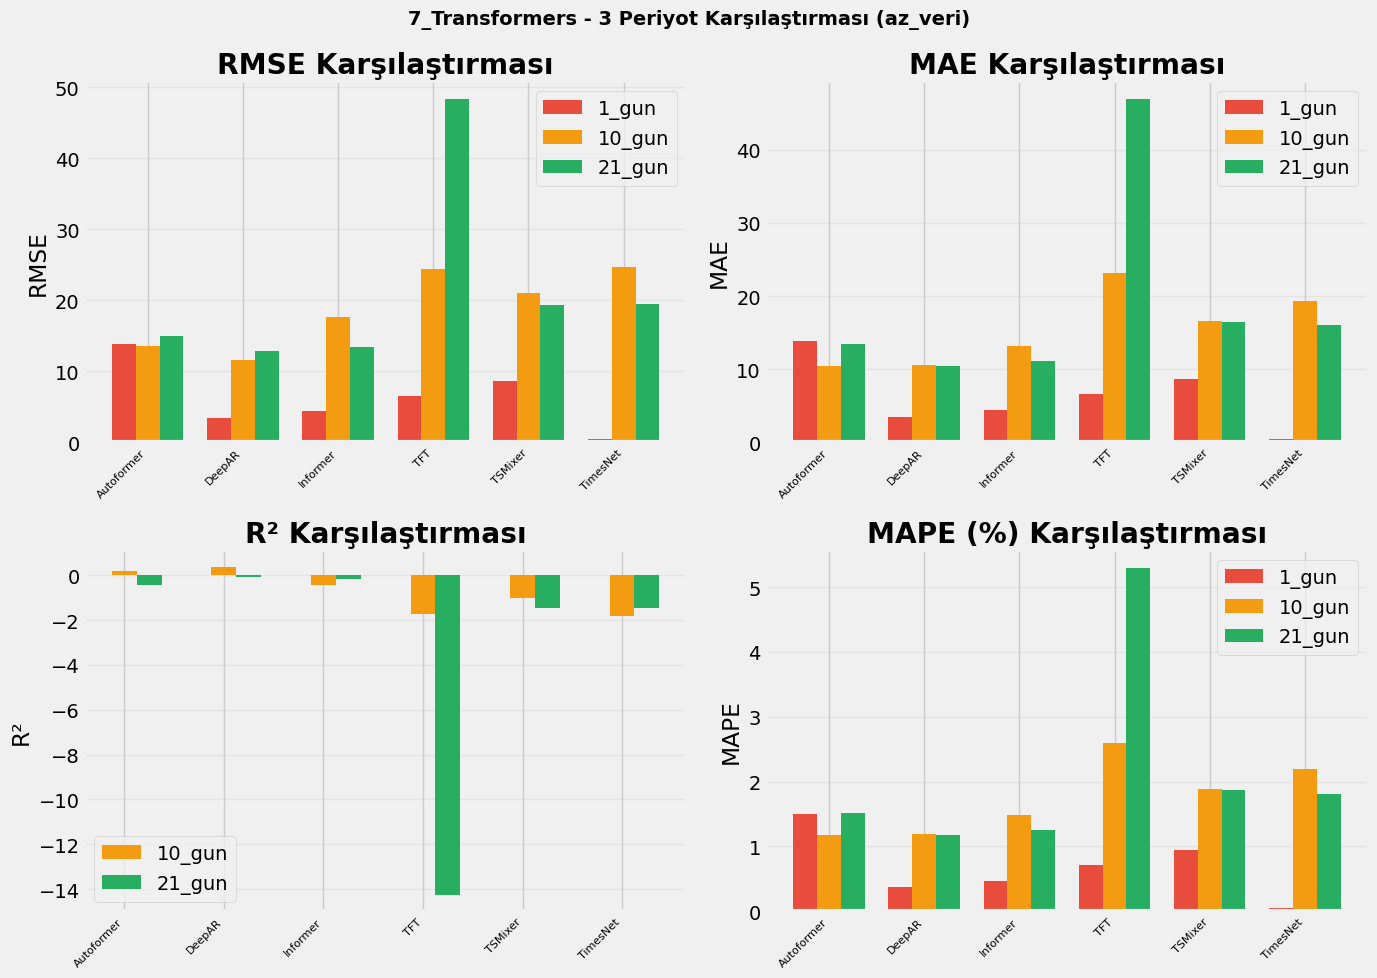


📈 Grafik kaydedildi: /content/drive/MyDrive/Colab Notebooks/Sonuclar/7_Transformers/7_Transformers_3periyot_karsilastirma.png


In [8]:
# =============================================================================
# KARŞILAŞTIRMA GRAFİKLERİ
# =============================================================================
if len(sonuc_df) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'{NOTEBOOK_ADI} - 3 Periyot Karşılaştırması ({VERI_TIPI})', fontsize=14, fontweight='bold')

    pivot_rmse = sonuc_df.pivot_table(index='Model', columns='Periyot', values='RMSE', aggfunc='first')
    pivot_mae = sonuc_df.pivot_table(index='Model', columns='Periyot', values='MAE', aggfunc='first')
    pivot_r2 = sonuc_df.pivot_table(index='Model', columns='Periyot', values='R2', aggfunc='first')
    pivot_mape = sonuc_df.pivot_table(index='Model', columns='Periyot', values='MAPE', aggfunc='first')

    models = pivot_rmse.index.tolist()
    x = np.arange(len(models))
    width = 0.25
    colors = ['#e74c3c', '#f39c12', '#27ae60']
    periyotlar = ['1_gun', '10_gun', '21_gun']

    for ax, pivot, title, ylabel in [(axes[0,0], pivot_rmse, 'RMSE', 'RMSE'),
                                      (axes[0,1], pivot_mae, 'MAE', 'MAE'),
                                      (axes[1,0], pivot_r2, 'R²', 'R²'),
                                      (axes[1,1], pivot_mape, 'MAPE (%)', 'MAPE')]:
        for i, periyot in enumerate(periyotlar):
            if periyot in pivot.columns:
                ax.bar(x + i*width, pivot[periyot].values, width, label=periyot, color=colors[i])
        ax.set_title(f'{title} Karşılaştırması', fontweight='bold')
        ax.set_ylabel(ylabel)
        ax.set_xticks(x + width)
        ax.set_xticklabels(models, rotation=45, ha='right', fontsize=8)
        ax.legend()
        ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.savefig(f"{RESULTS_DIR}/{NOTEBOOK_ADI}_3periyot_karsilastirma.png", dpi=150, bbox_inches='tight')
    plt.show()
    print(f"\n📈 Grafik kaydedildi: {RESULTS_DIR}/{NOTEBOOK_ADI}_3periyot_karsilastirma.png")

In [9]:
# =============================================================================
# EXCEL'E KAYDET
# =============================================================================
excel_dosya = f"{RESULTS_DIR}/{NOTEBOOK_ADI}_tum_sonuclar.xlsx"

with pd.ExcelWriter(excel_dosya, engine='openpyxl') as writer:
    sonuc_df.to_excel(writer, sheet_name='Tum_Sonuclar', index=False)
    if 'pivot_rmse' in dir():
        pivot_rmse.to_excel(writer, sheet_name='RMSE')
    if 'pivot_mae' in dir():
        pivot_mae.to_excel(writer, sheet_name='MAE')
    if 'pivot_r2' in dir():
        pivot_r2.to_excel(writer, sheet_name='R2')
    if 'pivot_mape' in dir():
        pivot_mape.to_excel(writer, sheet_name='MAPE')

print(f"\n✅ Sonuçlar kaydedildi: {excel_dosya}")
print("\n" + "=" * 80)
print(f" ÖZET - {NOTEBOOK_ADI}")
print("=" * 80)
print(f" Veri Tipi: {VERI_TIPI}")
print(f" Kategori: {KATEGORI}")
print(f" Modeller: Informer, Autoformer, TimesNet, DeepAR, TFT, TSMixer")
print(f" Periyotlar: 1 gün, 10 gün, 21 gün (HER BİRİ İÇİN AYRI EĞİTİM)")
print(f" Toplam Kayıt: {len(sonuc_df)}")
print("=" * 80)


✅ Sonuçlar kaydedildi: /content/drive/MyDrive/Colab Notebooks/Sonuclar/7_Transformers/7_Transformers_tum_sonuclar.xlsx

 ÖZET - 7_Transformers
 Veri Tipi: az_veri
 Kategori: Transformer
 Modeller: Informer, Autoformer, TimesNet, DeepAR, TFT, TSMixer
 Periyotlar: 1 gün, 10 gün, 21 gün (HER BİRİ İÇİN AYRI EĞİTİM)
 Toplam Kayıt: 18
